In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import sympy as sp
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline

# 忽略所有警告
import warnings
warnings.simplefilter("ignore")

# 7.1

In [2]:
class MetropolisHastings():
    def __init__(self) -> None:
        self.mu1, self.mu2 = 7, 10
        self.sigma1, self.sigma2 = 0.5**2, 0.5**2

    def DeltaPrior(self, delta):
        return np.logical_and(delta>=0, delta<1).astype(np.float32)
    
    def RandomWalk(self, delta_known, eps_low = -1, eps_up = 1, random_generator = None, U_space = False):
        if(U_space):
            upper_lim = delta_known + eps_up
            lower_lim = delta_known + eps_low
        else:
            upper_lim = min(delta_known + eps_up, 1)
            lower_lim = max(0, delta_known + eps_low)
        if(random_generator is None):
            new_delta = np.random.uniform(lower_lim, upper_lim, size = 1)
        else:
            new_delta = random_generator.uniform(lower_lim, upper_lim, size = 1)
        return new_delta

    def RandomWalkProb(self, delta, delta_known, eps_low = -1, eps_up = 1, U_space = False):
        if(U_space):
            upper_lim = delta_known + eps_up
            lower_lim = delta_known + eps_low
        else:
            upper_lim = min(delta_known + eps_up, 1)
            lower_lim = max(0, delta_known + eps_low)
        prob = 1/(upper_lim - lower_lim)
        return prob
    
    def DeltaProb(self, delta, data, mu1 = 7, mu2 = 10, sigma1 = 0.5**2, sigma2 = 0.5**2):
        part1 = delta*1/np.sqrt(sigma1*2*np.pi)*np.exp(-1/2*(data-mu1)**2/sigma1)
        part2 = (1-delta)*1/np.sqrt(sigma2*2*np.pi)*np.exp(-1/2*(data-mu2)**2/sigma2)
        prob = np.prod(part1 + part2)

        return prob

    def MixedNormSampling(self, num_distribution = 2, mus = np.array([7, 10]), sigmas = np.array([0.5**2, 0.5**2]), ratios = np.array([0.7, 1-0.7]), sample_size = 200, seed = 1024, is_plot = False):
        mus, sigmas, ratios = np.array(mus), np.array(sigmas), np.array(ratios)
        ratios = ratios/np.sum(ratios)

        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        U = rng.uniform(0, 1, sample_size)
        idxs = []
        sampling = np.zeros(sample_size)
        for i in range(num_distribution):
            lower = 0 + np.sum(ratios[:i])
            upper = 1 - np.sum(ratios[i+1:])
            idxs.append(np.where(np.logical_and(U >= lower, U < upper)))
            sampling[idxs[i]] = rng.normal(loc = mus[i], scale = sigmas[i], size = idxs[i][0].shape[0])
        if(is_plot):
            fig = plt.figure(figsize = (10, 5))
            bin_width = np.min(sigmas)/2
            sns.distplot(sampling, bins=np.arange(min(sampling), max(sampling) + bin_width, bin_width))
            fig.show()

        return sampling
    
    def Independencechain(self, data, num_iteration = 10000, seed = 1024, is_plot = False):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        delta = 0
        list_delta = []
        for t in range(num_iteration):
            tmp_delta = rng.uniform(0, 1, size = 1)
            R = min(1, self.DeltaProb(tmp_delta, data)/self.DeltaProb(delta, data)*self.DeltaPrior(delta)/self.DeltaPrior(tmp_delta))
            u = rng.uniform(0, 1, size = 1)
            if(u < R):
                delta = tmp_delta
            else:
                delta = delta
            list_delta.append(delta)
        list_delta = np.array(list_delta).reshape(-1)

        if(is_plot):
            fig = plt.figure(figsize = (15, 5))
            plt.title("Sample path of delta using independence chain MCMC")
            plt.plot(list_delta, "-", label = "delta")
            plt.xlabel("t")
            plt.ylabel("delta")
            plt.legend()
            fig.show()

        return list_delta
    
    def RandomWalkChain(self, data, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, U_space = False, is_plot = False):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        delta = 0
        list_delta = []
        if(U_space):
            U = 0
            delta = 1/(np.exp(-U) + 1)
            jacob = np.exp(-U)*delta**2
            for t in range(num_iteration):
                tmp_U = self.RandomWalk(U, eps_lower, eps_upper, rng, U_space)
                tmp_delta = 1/(np.exp(-tmp_U) + 1)
                tmp_jacob = np.exp(-tmp_U)*tmp_delta**2
                R = min(1, self.DeltaProb(tmp_delta, data)/self.DeltaProb(delta, data))*self.RandomWalkProb(U, tmp_U, eps_lower, eps_upper, U_space)/self.RandomWalkProb(tmp_U, U, eps_lower, eps_upper, U_space)*jacob/tmp_jacob
                u = rng.uniform(0, 1, size = 1)
                if(u < R):
                    U = tmp_U
                    delta = tmp_delta
                    jacob = tmp_jacob
                list_delta.append(delta)
        else:
            for t in range(num_iteration):
                tmp_delta = self.RandomWalk(delta, eps_lower, eps_upper, rng)
                R = min(1, self.DeltaProb(tmp_delta, data)/self.DeltaProb(delta, data))*self.RandomWalkProb(delta, tmp_delta, eps_lower, eps_upper)/self.RandomWalkProb(tmp_delta, delta, eps_lower, eps_upper)
                u = rng.uniform(0, 1, size = 1)
                if(u < R):
                    delta = tmp_delta
                list_delta.append(delta)

        list_delta = np.array(list_delta).reshape(-1)

        if(is_plot):
            fig = plt.figure(figsize = (15, 5))
            plt.title("Sample path of delta using random walk chain MCMC")
            label_ = "Random walk step ~ U(%.2f, %.2f)"%(eps_lower, eps_upper)
            if(U_space):
                label_ += " in U space"
            plt.plot(list_delta, "-", label = label_)
            plt.xlabel("t")
            plt.ylabel("delta")
            plt.legend()
            fig.show()

        return list_delta

    def PlotCompare(self):
        names = ["ID Chain", "RW(-1, 1) delta", "RW(-0.01, 0.01) delta", "RW(-1, 1) U", "RW(-0.01, 0.01) U"]
        mixed_norm_sample = self.MixedNormSampling(num_distribution = 2, mus = [7, 10], sigmas = [0.5**2, 0.5**2], ratios = [0.7, 1-0.7], sample_size = 200, seed = 1024, is_plot = False)
        independence_chain_deltaMC = self.Independencechain(mixed_norm_sample, num_iteration = 10000, seed = 1024, is_plot = False)
        randomwalk_chain_deltaMC1 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = False)
        randomwalk_chain_deltaMC2 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = False)
        randomwalk_chain_deltaMC3 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = False, U_space =  True)
        randomwalk_chain_deltaMC4 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = False, U_space =  True)
        results = np.array([independence_chain_deltaMC, randomwalk_chain_deltaMC1, randomwalk_chain_deltaMC2, randomwalk_chain_deltaMC3, randomwalk_chain_deltaMC4])

        fig = plt.figure(figsize = (10, 5))
        plt.boxplot(results.T)
        plt.xticks(range(1, len(names) + 1), names)
        plt.grid(True)
        fig.show()

In [3]:
mh = MetropolisHastings()

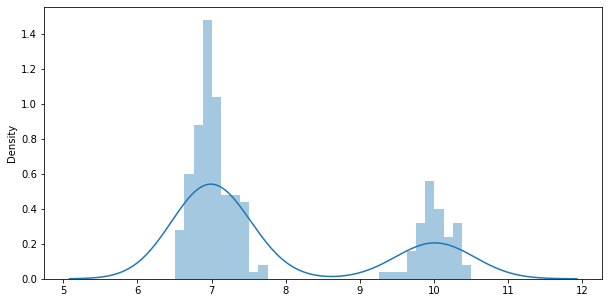

In [4]:
mixed_norm_sample = mh.MixedNormSampling(num_distribution = 2, mus = [7, 10], sigmas = [0.5**2, 0.5**2], ratios = [0.7, 1-0.7], sample_size = 200, seed = 1024, is_plot = True)

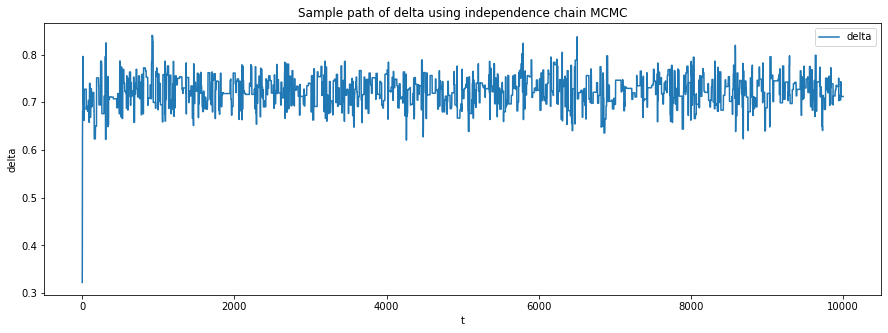

In [5]:
independence_chain_deltaMC = mh.Independencechain(mixed_norm_sample, num_iteration = 10000, seed = 1024, is_plot = True)

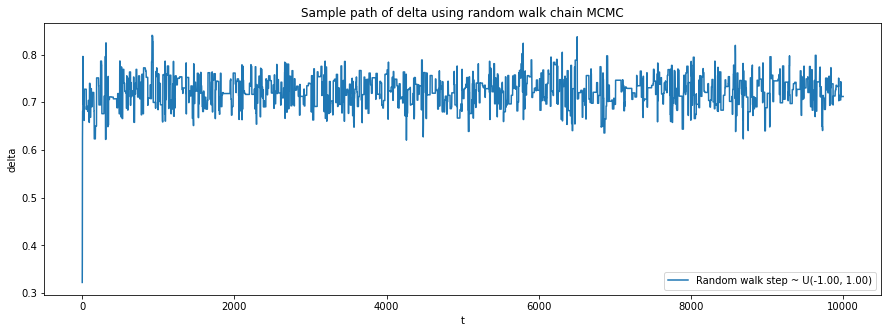

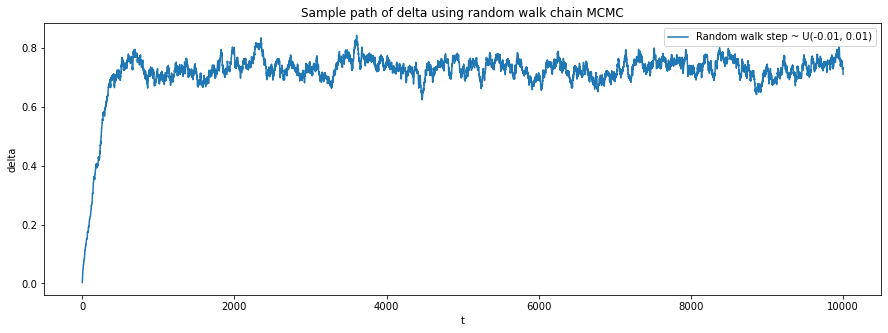

In [6]:
randomwalk_chain_deltaMC1 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = True)
randomwalk_chain_deltaMC2 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = True)

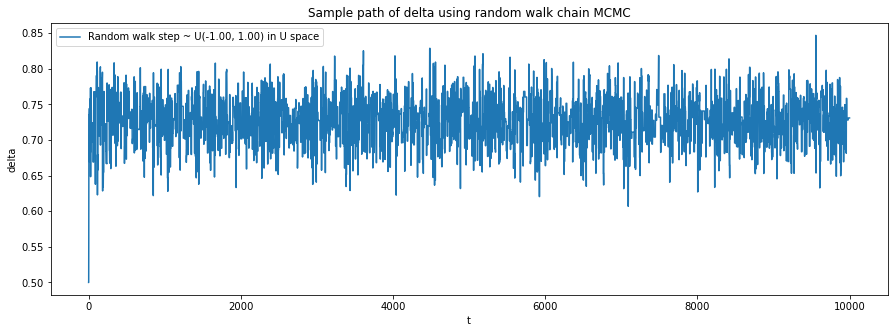

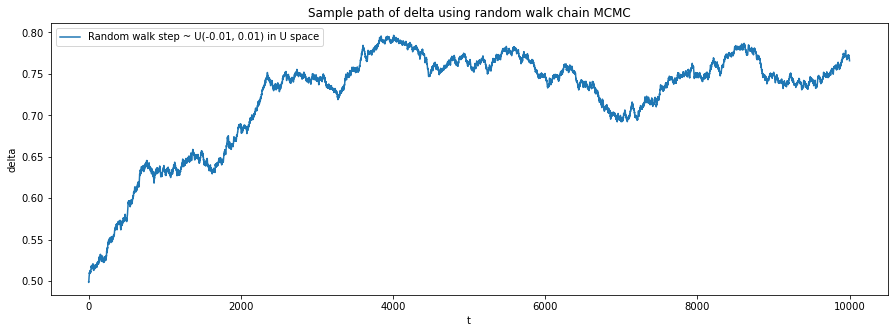

In [7]:
randomwalk_chain_deltaMC3 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = True, U_space =  True)
randomwalk_chain_deltaMC4 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = True, U_space =  True)

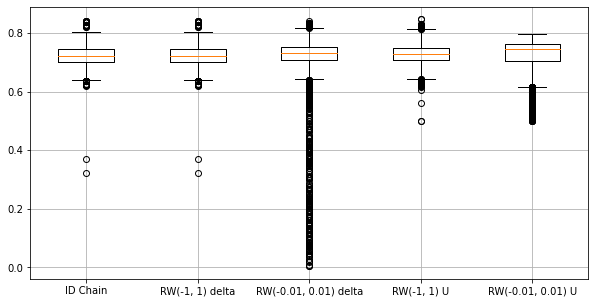

In [8]:
mh.PlotCompare()

# 7.5

In [9]:
class Exponential():
    def __init__(self, 
                 recu_exp = np.array([2,4,6,9,9,9,13,14,18,23,31,32,33,34,43]), 
                 cens_exp = np.array([10,14,14,16,17,18,18,19,20,20,21,21,23,24,29,29,30,30,31,31,31,33,35,37,40,41,42,42,44,46,48,49,51,53,54,54,55,56]), 
                 recu_con = np.array([1,4,6,7,13,24,25,35,35,39]), 
                 cens_con = np.array([1,1,3,4,5,8,10,11,13,14,14,15,17,19,20,22,24,24,24,25,26,26,26,28,29,29,32,35,38,39,40,41,44,45,47,47,47,50,50,51])) -> None:
        from scipy.special import gamma
        self.recu_exp, self.cens_exp, self.recu_con, self.cens_con = np.array(recu_exp), np.array(cens_exp), np.array(recu_con), np.array(cens_con)
        self.data_exp = np.concatenate([self.recu_exp, self.cens_exp])
        self.mask_exp = np.concatenate([np.ones(self.recu_exp.shape), np.zeros(self.cens_exp.shape)])
        self.data_con = np.concatenate([self.recu_con, self.cens_con])
        self.mask_con = np.concatenate([np.ones(self.recu_con.shape), np.zeros(self.cens_con.shape)])

        self.a, self.b, self.c, self.d = 3, 1, 60, 120
        
        self.F_gamma = gamma

    def PlotData(self):
        bin_width = 5
        plt.figure(figsize = (20, 10))
        plt.subplot(2, 2, 1)
        sns.distplot(self.recu_exp, color = "red", label = "Recurrence times (Hormone)", bins=np.arange(min(self.recu_exp), max(self.recu_exp) + bin_width, bin_width))
        plt.title("Recurrence times (Hormone)")
        plt.grid(True)

        plt.subplot(2, 2, 2)
        sns.distplot(self.cens_exp, color = "green", label = "Censoring times (Hormone)", bins=np.arange(min(self.cens_exp), max(self.cens_exp) + bin_width, bin_width))
        plt.title("Censoring times (Hormone)")
        plt.grid(True)

        plt.subplot(2, 2, 3)
        sns.distplot(self.recu_con, color = "blue", label = "Recurrence times (Control)", bins=np.arange(min(self.recu_con), max(self.recu_con) + bin_width, bin_width))
        plt.title("Recurrence times (Control)")
        plt.grid(True)

        plt.subplot(2, 2, 4)
        sns.distplot(self.cens_con, color = "orange", label = "Censoring times (Control)", bins=np.arange(min(self.cens_con), max(self.cens_con) + bin_width, bin_width))
        plt.title("Censoring times (Control)")
        plt.grid(True)

        plt.show()
    
    def Prior(self, tau, a = 3, b = 1, c = 60, d = 120):
        part1 = c**(a-b)*d**(b+1)*self.F_gamma(a+1)/(self.F_gamma(a-b)*self.F_gamma(b+1))
        part2 = (d*tau+c)**(-a-1)*tau**b
        ret = part1*part2

        return ret

    def ConjugatePrior(self, theta, tau, a = 3, b = 1, c=60, d=120):
        return (theta**a)*(tau**b)*np.exp(-c*theta-d*tau*theta)
    
    def condProb(self, theta, tau, known = "theta", a = 3, b = 1, c=60, d=120):
        if(known == "theta"):
            part1 = (tau**b)*np.exp(-d*theta*tau)
            part2 = ((d*theta)**(-b-1))*self.F_gamma(b+1)
        elif(known == "tau"):
            part1 = (theta**a)*np.exp(-c*theta-d*theta*tau)
            part2 = ((d*tau+c)**(-a-1))*self.F_gamma(a+1)
        
        ret = part1/part2
        return ret
    
    def GibbsSampling(self, a = 3, b = 1, c = 60, d = 120, sample_size = 10000, seed = 1024, is_plot = False):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        theta, tau = 0, 0
        sample = [[theta, tau]]
        for i in range(sample_size):
            theta = rng.gamma(shape = a+1, scale = 1/(d*tau+c), size = 1)
            tau = rng.gamma(shape = b+1, scale = 1/(d*theta), size = 1)
            sample.append([float(theta), float(tau)])
        sample = np.array(sample)

        if(is_plot):
            plt.figure(figsize = (10, 5))
            plt.subplot(2,1,1)
            plt.plot(sample[:, 0], ".", color = "red", label = "theta")
            plt.legend()

            plt.subplot(2,1,2)
            plt.plot(sample[:, 1], "x", color = "green", label = "tau")
            plt.legend()
            
            plt.show()

        return sample

    def BurnLength(self, num_chain = 10, d_burn = 0, sample_size = 10000):
        chains = []
        for seed in range(num_chain):
            chain = self.GibbsSampling(sample_size = sample_size, seed = seed)
            chain = chain[d_burn:]
            chains.append(chain)
        chains = np.array(chains)
        L = sample_size - d_burn
        means = np.array([np.mean(chain, axis=0) for chain in chains])
        vars = np.array([1/(L-1)*np.sum((chains[i]-mean)**2, axis=0) for i, mean in enumerate(means)])
        mean = np.mean(means, axis=0)
        B = L/(num_chain-1)*np.sum((means - mean)**2, axis=0)
        W = np.mean(vars, axis=0)

        R = ((L-1)/L*W + 1/L*B)/W
        R_hat = (num_chain+1)/num_chain*R - (L-1)/(num_chain*L)

        return R_hat
    
    def PrintStatics(self, sample, is_plot = False, is_print = True):
        names = ["theta", "tau"]
        columns = ["marginal mean", "std", "95% interval LB", "95% interval UB"]
        table = []
        table.append(np.mean(sample, axis=0))
        table.append(np.std(sample, axis=0))
        table.append(np.percentile(sample, 2.5, axis=0))
        table.append(np.percentile(sample, 97.5, axis=0))
        table = np.array(table)
        table = pd.DataFrame(table.T)
        table.index = names
        table.columns = columns

        if(is_print):
            print(table)

        if(is_plot):
            fig = plt.figure(figsize = (10, 5))
            plt.subplot(1,2,1)
            plt.boxplot(sample[:, 0])
            plt.xticks(range(1, 2), [names[0]])
            plt.grid(True)

            plt.subplot(1,2,2)
            plt.boxplot(sample[:, 1])
            plt.xticks(range(1, 2), [names[1]])
            plt.grid(True)

            fig.show()
        return table

    def PlotPriorPosterior_tau(self, sample_size = 10000):
        
        gibbs_sample = self.GibbsSampling(sample_size = sample_size)
        unique, counts = np.unique(gibbs_sample[:, 1], return_counts = True)
        priors = self.Prior(unique)
        fig = plt.figure(figsize = (10, 5))
        plt.plot(unique, priors, "-", color="red", label = "prior of tau")
        sns.kdeplot(gibbs_sample[:, 1], color="green", label = "estimated posterior of tau", bw_adjust = 0.05)
        plt.legend()
        fig.show()

    def SensitivityAnalysis(self, a = 3, b = 1, c = 60, d = 120, sample_size = 10000, seed = 1024):
        sample1 = self.GibbsSampling(a = a, b = b, c = c, d = d, sample_size = sample_size, seed = seed)
        sample2 = self.GibbsSampling(a = a/2, b = b/2, c = c/2, d = d/2, sample_size = sample_size, seed = seed)
        sample3 = self.GibbsSampling(a = a*2, b = b*2, c = c*2, d = d*2, sample_size = sample_size, seed = seed)
        samples = [sample1, sample2, sample3]
        tables = [self.PrintStatics(sample, is_print = False) for sample in samples]

        print("The statics of origin hyperparemeters:")
        print(tables[0])
        print()
        print("The statics of origin hyperparemeters divide by 2:")
        print(tables[1])
        print()
        print("The statics of origin hyperparemeters times 2:")
        print(tables[2])

In [10]:
recu_exp = np.array([2,4,6,9,9,9,13,14,18,23,31,32,33,34,43])
cens_exp = np.array([10,14,14,16,17,18,18,19,20,20,21,21,23,24,29,29,30,30,31,31,31,33,35,37,40,41,42,42,44,46,48,49,51,53,54,54,55,56])
recu_con = np.array([1,4,6,7,13,24,25,35,35,39])
cens_con = np.array([1,1,3,4,5,8,10,11,13,14,14,15,17,19,20,22,24,24,24,25,26,26,26,28,29,29,32,35,38,39,40,41,44,45,47,47,47,50,50,51])

In [11]:
exponential = Exponential(recu_exp, cens_exp, recu_con, cens_con)

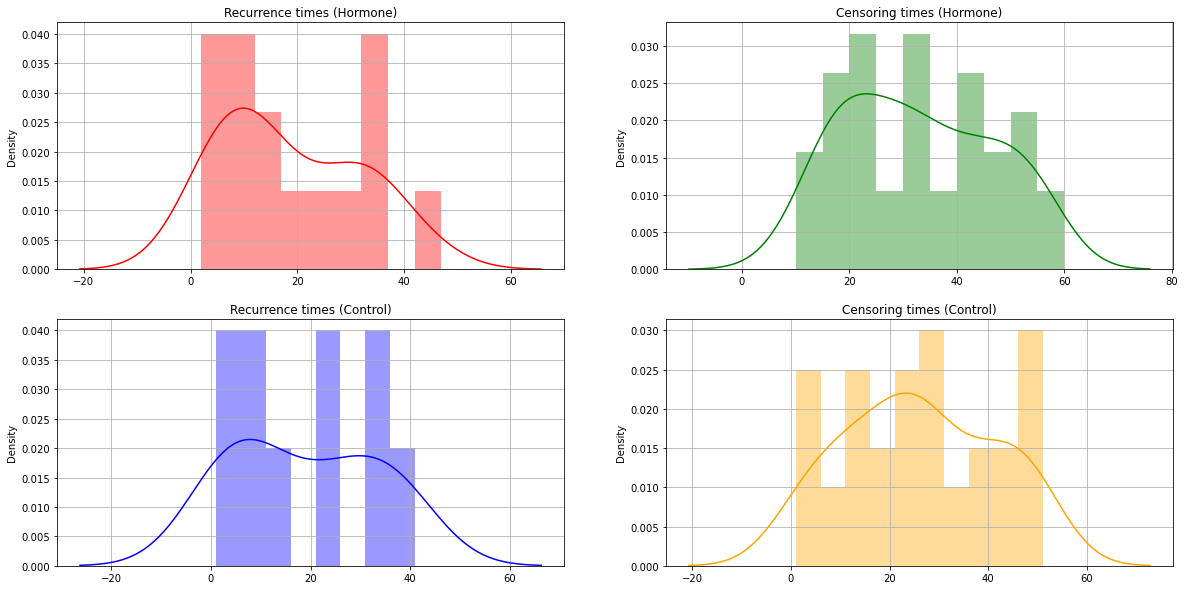

In [12]:
exponential.PlotData()

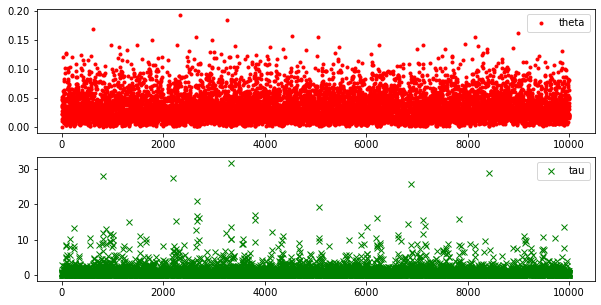

Using Burn-in and Run Length method, get R_theta = 1.000192, R_tau = 1.000344


In [13]:
gibbs_sample = exponential.GibbsSampling(is_plot = True)
R_score = exponential.BurnLength()
print("Using Burn-in and Run Length method, get R_theta = %f, R_tau = %f"%(R_score[0], R_score[1]))

       marginal mean       std  95% interval LB  95% interval UB
theta       0.034032  0.023688         0.004239         0.094301
tau         0.916754  1.523507         0.052322         4.537479


,marginal mean,std,95% interval LB,95% interval UB
theta,0.034032,0.023688,0.004239,0.094301
tau,0.916754,1.523507,0.052322,4.537479


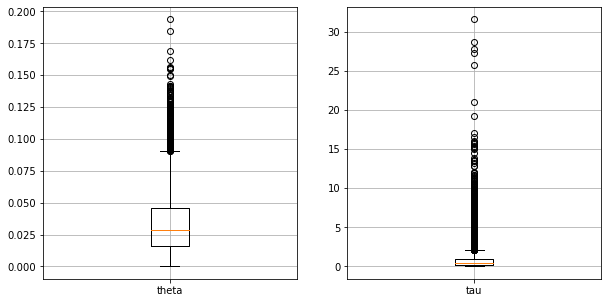

In [14]:
exponential.PrintStatics(gibbs_sample, is_plot=True)

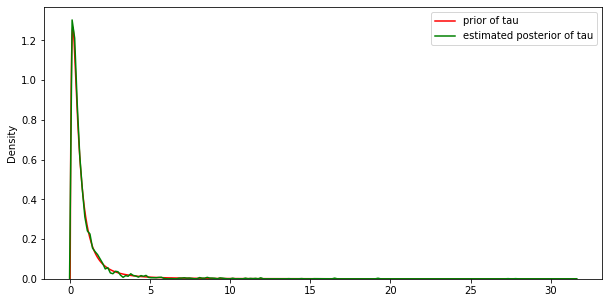

In [15]:
exponential.PlotPriorPosterior_tau()

In [16]:
exponential.SensitivityAnalysis()

The statics of origin hyperparemeters:
       marginal mean       std  95% interval LB  95% interval UB
theta       0.034032  0.023688         0.004239         0.094301
tau         0.916754  1.523507         0.052322         4.537479

The statics of origin hyperparemeters divide by 2:
       marginal mean        std  95% interval LB  95% interval UB
theta       0.033225   0.033424         0.000729         0.122396
tau         5.244312  33.200553         0.046139        32.349776

The statics of origin hyperparemeters times 2:
       marginal mean       std  95% interval LB  95% interval UB
theta       0.033540  0.016717         0.008956         0.073503
tau         0.496958  0.478717         0.067289         1.824140


# 7.7